In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

from scipy import optimize

In [70]:
plt.style.use('notebook')

In [3]:
t = Table(fits.getdata('../data/pal5_ls_lite_gr.fits'))

In [4]:
ceq = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')
cpal = ceq.transform_to(gc.Pal5)

wangle = 180*u.deg

In [7]:
points = np.array([t['g']-t['r'], t['g']]).T

## Top panel: Map

### CMD mask for preliminary map

In [5]:
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [8]:
# distance moduli are different for the leading and trailing arms
cmd_masks = []
for dist in [19,23]:
    distance_app = dist*u.kpc
    dm = 5*np.log10((distance_app.to(u.pc)).value)-5

    # main sequence + rgb
    i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
    i_g = iso['DECam_g']+dm
    i_r = iso['DECam_r']+dm

    i_left = i_gr - 0.12*(i_g/28)**5
    i_right = i_gr + 0.12*(i_g/28)**5

    poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1]<23.7) & (poly[:,1]>20)
    poly_main = poly[ind]
    path_main = mpl.path.Path(poly_main)
    
    cmd_masks += [path_main.contains_points(points)]

In [10]:
# combine individual masks
ra0 = 229.022083*u.deg
dec0 = -0.111389*u.deg

ra_masks = [[ceq.ra<ra0], [ceq.ra>=ra0]]

mask = ((cmd_masks[0] & ra_masks[0]) | (cmd_masks[1] & ra_masks[1]))[0]

### CMD regions

In [13]:
# parabola along Pal5
p = [0.018,0.14,-0.7]
poly_track_coarse = np.poly1d(p)

In [14]:
delta_phi2 = 0.4
phi2_mask = ((cpal.phi2.deg<poly_track_coarse(cpal.phi1.wrap_at(wangle).deg ) + delta_phi2) & 
             (cpal.phi2.deg>poly_track_coarse(cpal.phi1.wrap_at(wangle).deg) - delta_phi2))

In [31]:
bin_spacing = 3*u.deg
bin_width = 3*u.deg

be0 = np.arange(-15, 10, bin_spacing.to(u.deg).value)*u.deg
be1 = be0 + bin_width
be = np.concatenate([be0.value, [be1[-1].value]])

bc = 0.5 * (be0 + be1)
N = np.size(bc)

In [39]:
x_grid = np.linspace(-15,12,100)
y_grid = poly_track_coarse(x_grid)

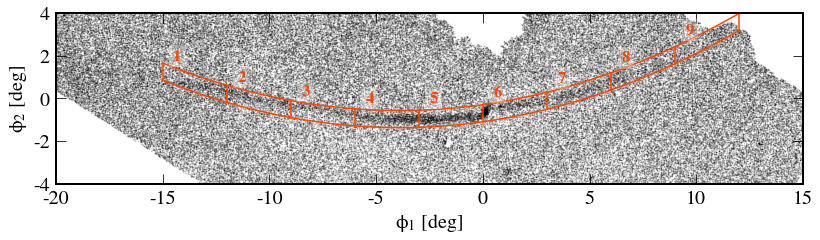

In [115]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

# plt.plot(cpal.phi1.wrap_at(wangle)[mask], cpal.phi2[mask], 'k.', ms=1, alpha=0.12, rasterized=True)
plt.plot(cpal.phi1.wrap_at(wangle)[mask], cpal.phi2[mask], 'k.', ms=1, alpha=0.2, rasterized=True)

plt.plot(x_grid, y_grid + delta_phi2, '-', color='orangered', lw=1.5)
plt.plot(x_grid, y_grid - delta_phi2, '-', color='orangered', lw=1.5)

for e in range(N+1):
    if e<N:
        txt = plt.text(be[e]+0.5, poly_track_coarse(be[e]+0.5)+0.75,
                 '{:d}'.format(e+1), color='orangered', fontsize='small', weight='bold')
        txt.set_bbox(dict(facecolor='w', alpha=0.3, ec='none'))
    
    x_vert = np.ones(2) * be[e]
    y_vert = np.array([delta_phi2, -delta_phi2])
    y_vert += poly_track_coarse(x_vert)
    plt.plot(x_vert, y_vert, '-', color='orangered', lw=1.5)
    
    

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-4,4)
plt.xlim(-20,15)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('../paper/fig1_a_map.pdf')

## Bottom panels: CMDS

### Distance modulus variation

In [ ]:
delta_dm = np.zeros(N)
# by eye from histograms
delta_dm[8] = -0.6
delta_dm[7] = -0.35
delta_dm[6] = -0.15

# delta_dm[8] = -0.3
# delta_dm[7] = -0.15
# delta_dm[6] = -0.05
# delta_dm[4] = -0.02

# guess
delta_dm[1] = 0.08
delta_dm[2] = 0.06
delta_dm[3] = 0.04
delta_dm[4] = 0.02

# from ibata+2016
delta_dm[0] = 0.1

In [85]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [86]:
p_dm, e = optimize.curve_fit(piecewise_linear, bc, delta_dm)

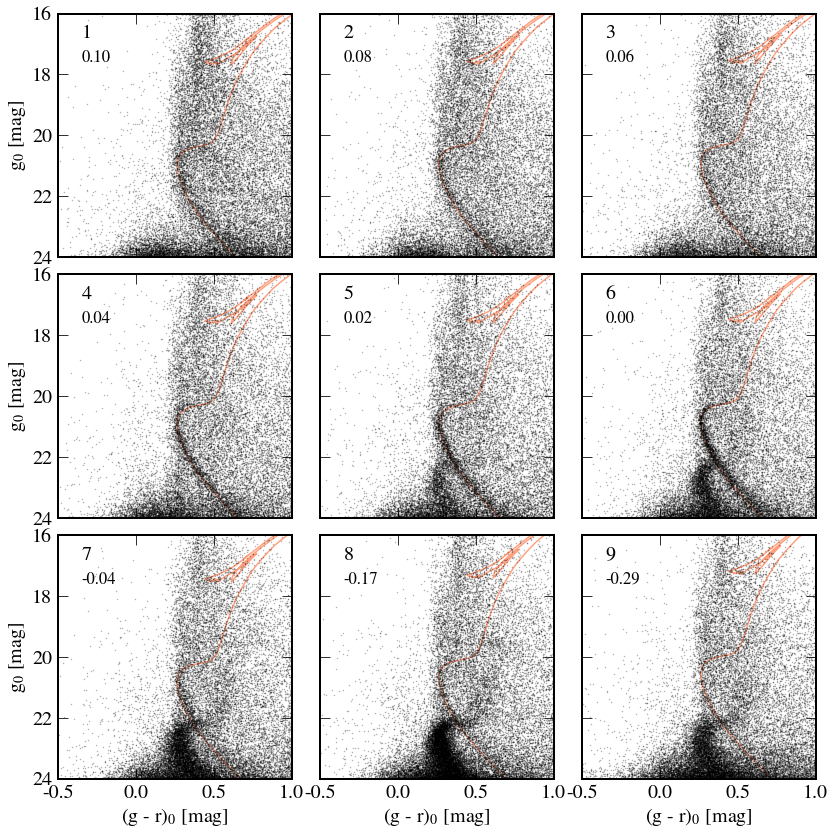

In [126]:
fig, ax = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)

for i in range(N):
    irow = np.int64(i/3)
    icol = i%3
    plt.sca(ax[irow][icol])
    
    ind = phi2_mask & (cpal.phi1.wrap_at(wangle)>be0[i]) & (cpal.phi1.wrap_at(wangle)<=be1[i])
    plt.plot(t['g'][ind] - t['r'][ind], t['g'][ind], 'k.', ms=1, alpha=0.3, rasterized=True)
    
    delta_dm = piecewise_linear(bc[i].value, *p_dm)
    plt.plot(i_gr, i_g + delta_dm, '-', color='orangered', lw=1.5, alpha=0.5, zorder=0)

    plt.text(0.1, 0.9, '{:d}'.format(i+1), transform=plt.gca().transAxes)
    if np.abs(delta_dm)<1e-4: delta_dm = 0
    plt.text(0.1, 0.8, '{:.2f}'.format(delta_dm), transform=plt.gca().transAxes, fontsize='small')
    plt.xlim(-0.5,1)
    plt.ylim(24,16)

for i in range(3):
    plt.sca(ax[i][0])
    plt.ylabel('$g_0$ [mag]')
    
    plt.sca(ax[2][i])
    plt.xlabel('(g - r)$_0$ [mag]')

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('../paper/fig1_b_cmds.pdf')